[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pchok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



>>> ChromaDB collection already has 10 documents.
Skipping PubMed fetch, using existing data.


Device set to use cpu
c:\Users\pchok\anaconda3\Lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(



Using device=-1 ('cuda:0' if 0, 'cpu' if -1)


Dense Retrieval Results: {'ids': [['40010238', '40013176', '40012625', '40009619', '40014274']], 'embeddings': None, 'documents': [['Multiple sclerosis (MS) is an autoimmune neurodegenerative disease affecting the central nervous system. MS diagnosis is complex, requiring magnetic resonance imaging and cerebrospinal fluid analysis due to the lack of definitive biomarkers. Although treatment advancements have reduced disability, diagnostic and therapeutic challenges remain, even among MS-specialized neurologists. Artificial Intelligence (AI) tools, which analyze large datasets, are increasingly used in healthcare, especially for diagnosis and treatment.', 'To obtain detailed data on the acceptance of an artificial intelligence chatbot (ChatGPT; OpenAI, San Francisco, CA, USA) in ophthalmology among physicians, a survey explored physician responses regarding using ChatGPT in ophthalmology. The survey included questions about the application

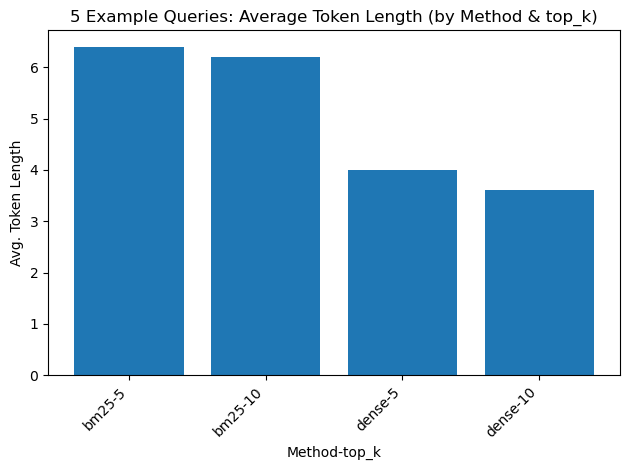

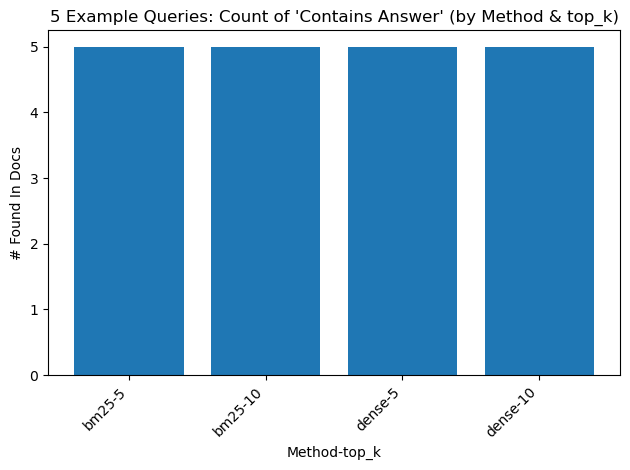

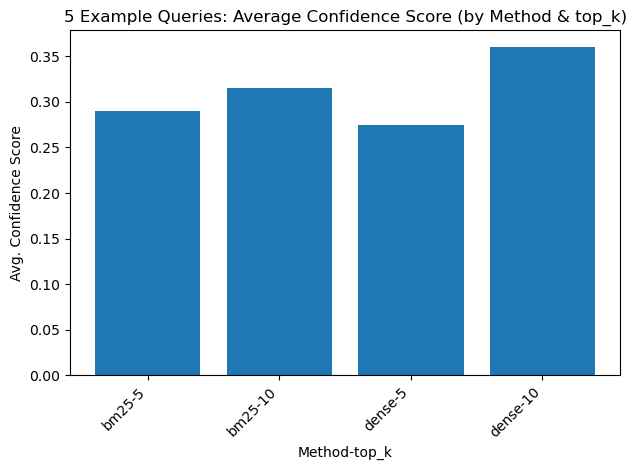


--- INTERACTIVE MODE (TEST ALL COMBOS) ---


c:\Users\pchok\anaconda3\Lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(



Dense Retrieval Results: {'ids': [['40010810', '40014274', '40012602', '40011748', '40009619']], 'embeddings': None, 'documents': [['Cognitive-behavioural therapy (CBT) works-but not equally well for all patients. Less than 50% of patients with internalising disorders achieve clinically meaningful improvement, with negative consequences for patients and healthcare systems. The research unit (RU) 5187 seeks to improve this situation by an in-depth investigation of the phenomenon of treatment non-response (TNR) to CBT. We aim to identify bio-behavioural signatures associated with TNR, develop predictive models applicable to individual patients and enhance the utility of predictive analytics by collecting a naturalistic cohort with high ecological validity for the outpatient sector.', 'This position paper aims to address the challenges of managing type 2 diabetes mellitus (T2DM) in frail older adults, a diverse and growing demographic with significant variability in health status. The pr

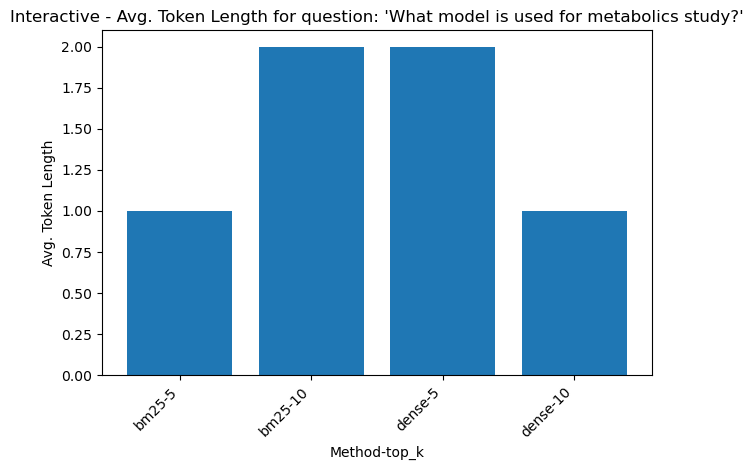

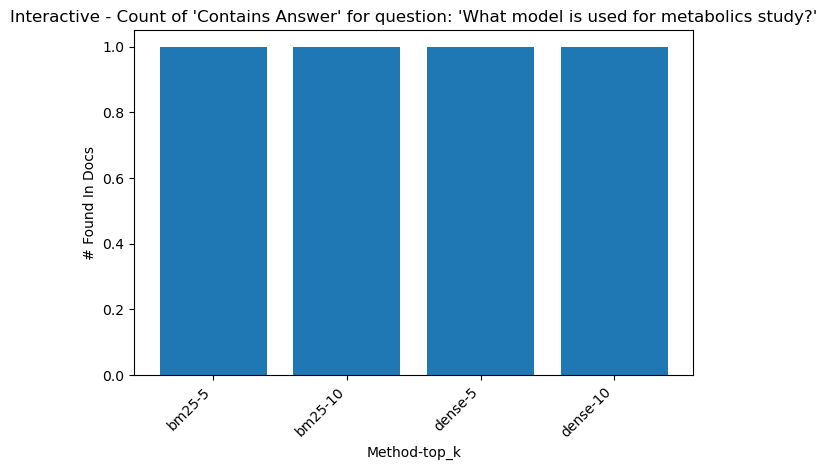

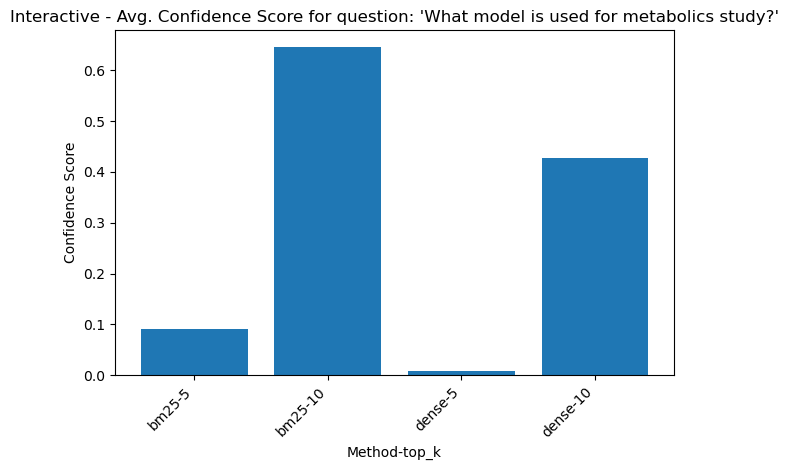

c:\Users\pchok\anaconda3\Lib\site-packages\transformers\pipelines\question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(



Dense Retrieval Results: {'ids': [['40010238', '40012602', '40013176', '40014274', '40012625']], 'embeddings': None, 'documents': [['Multiple sclerosis (MS) is an autoimmune neurodegenerative disease affecting the central nervous system. MS diagnosis is complex, requiring magnetic resonance imaging and cerebrospinal fluid analysis due to the lack of definitive biomarkers. Although treatment advancements have reduced disability, diagnostic and therapeutic challenges remain, even among MS-specialized neurologists. Artificial Intelligence (AI) tools, which analyze large datasets, are increasingly used in healthcare, especially for diagnosis and treatment.', 'This study aims to address the critical issue of emergency department (ED) overcrowding, which negatively affects patient outcomes, wait times, and resource efficiency. Accurate prediction of ED length of stay (LOS) can streamline operations and improve care delivery. We utilized the MIMIC IV-ED dataset, comprising over 400,000 patie

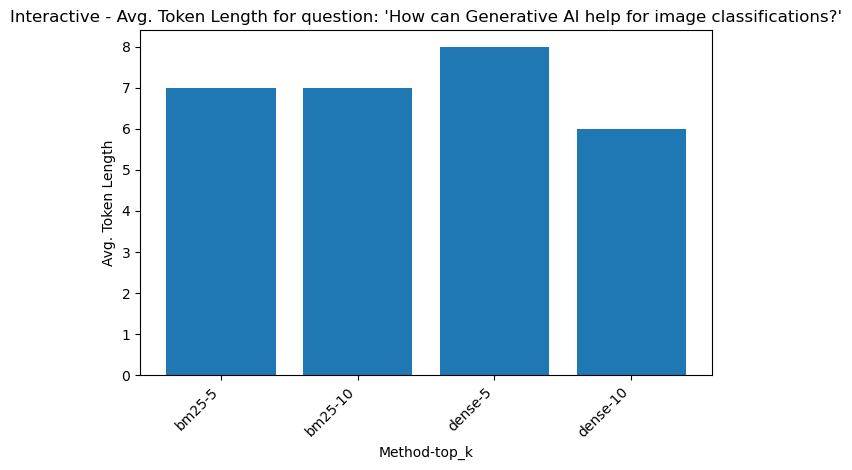

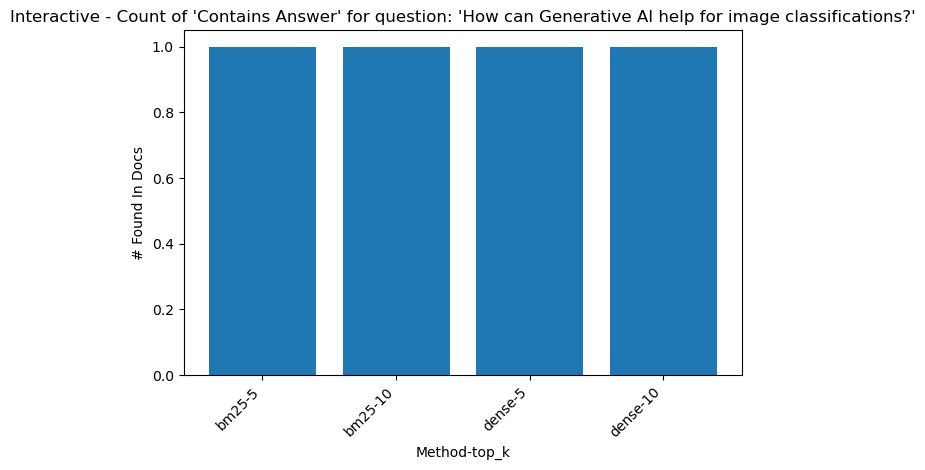

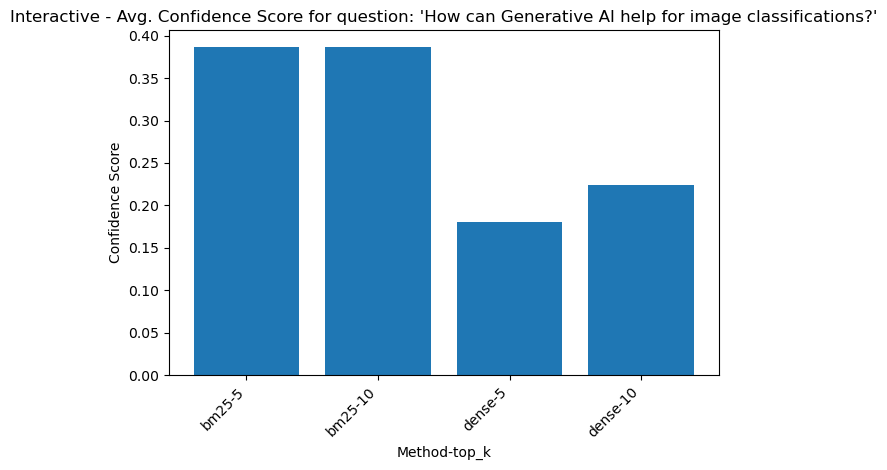

Exiting. Goodbye!


In [ ]:
"""
Task 3: Retrieval-Augmented Generation (RAG) Pipeline

This revised script:
- Prints each question and answer in the terminal/console for 5 example queries (BM25 & dense, top_k=5/10).
- Shows bar charts (token length, 'contains_answer' count, confidence).
- In interactive mode, it does the same for any user question, again printing question+answers and showing charts.
"""

import sys
from Bio import Entrez
import chromadb
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import pandas as pd
import matplotlib.pyplot as plt

# 1) ENV SETUP
nltk.download("punkt")
Entrez.email = "choksi.pr@northeastern.edu"

# If you want GPU usage, set USE_GPU = True, else it uses CPU
USE_GPU = False
DEVICE_ID = 0 if USE_GPU else -1

# 2) CHROMADB INIT
chroma_client = chromadb.PersistentClient(path="chroma_store")
collection_name = "scientific_papers_interactive"
collection = chroma_client.get_or_create_collection(collection_name)

# 3) SENTENCE TRANSFORMER
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# ---------------------------
# PUBMED FETCH & INDEX
# ---------------------------
def fetch_pubmed_data(query, max_results=10):
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()

    id_list = record.get("IdList", [])
    if not id_list:
        print("No PubMed articles found for query:", query)
        return []

    handle = Entrez.efetch(db="pubmed", id=id_list, rettype="xml")
    papers = Entrez.read(handle)
    handle.close()

    results = []
    for paper in papers.get('PubmedArticle', []):
        title = paper['MedlineCitation']['Article']['ArticleTitle']
        abstract = paper['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', [""])[0]
        results.append({
            "id": paper['MedlineCitation']['PMID'],
            "title": title,
            "abstract": abstract,
            "text": abstract
        })
    return results

def index_papers(papers):
    for paper in papers:
        emb = embedding_model.encode(paper["text"]).tolist()
        collection.add(
            ids=[paper["id"]],
            embeddings=[emb],
            metadatas=[{"title": paper["title"], "abstract": paper["abstract"]}],
            documents=[paper["text"]]
        )

def maybe_fetch_and_index_papers(query, max_results=10):
    existing_count = collection.count()
    if existing_count > 0:
        print(f"\n>>> ChromaDB collection already has {existing_count} documents.")
        choice = input("Skip fetching from PubMed? (y/n) [default: y] >> ").strip().lower()
        if choice in ["n", "no"]:
            print("Deleting existing docs and fetching new ones...")
            collection.delete()
            new_papers = fetch_pubmed_data(query, max_results)
            if new_papers:
                index_papers(new_papers)
            else:
                print("No new papers fetched.")
        else:
            print("Skipping PubMed fetch, using existing data.")
    else:
        print("ChromaDB collection is empty. Fetching new documents from PubMed...")
        new_papers = fetch_pubmed_data(query, max_results)
        if new_papers:
            index_papers(new_papers)
        else:
            print("No papers fetched from PubMed.")

maybe_fetch_and_index_papers("AI in healthcare", max_results=10)

all_docs = collection.get()
documents = all_docs.get("documents", [])
if not documents:
    print("No documents in ChromaDB. Exiting.")
    sys.exit(0)

tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]
bm25 = BM25Okapi(tokenized_docs)

def retrieve_bm25(query, top_k=5):
    t_query = word_tokenize(query.lower())
    scores = bm25.get_scores(t_query)
    top_n_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    return [documents[i] for i in top_n_indices]

def retrieve_dense(query, top_k=5):
    emb = embedding_model.encode(query).tolist()
    results = collection.query(query_embeddings=[emb], n_results=top_k)
    print("\nDense Retrieval Results:", results)
    if not results.get("documents"):
        return []
    return results["documents"][0]

# QA MODEL
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")
qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer,
    device=DEVICE_ID  # 0 => GPU, -1 => CPU
)

print(f"\nUsing device={DEVICE_ID} ('cuda:0' if 0, 'cpu' if -1)\n")

# EVALUATION
def check_retrieval_effectiveness(answer, retrieved_docs):
    ans_lower = answer.lower()
    for doc in retrieved_docs:
        if ans_lower in doc.lower():
            return True
    return False

def evaluate_response(query, retrieval_method="dense", top_k=5):
    if retrieval_method == "bm25":
        docs = retrieve_bm25(query, top_k)
    else:
        docs = retrieve_dense(query, top_k)

    if not docs:
        return {
            "question": query,
            "retrieval_method": retrieval_method,
            "top_k": top_k,
            "answer": "No documents retrieved.",
            "token_length": 0,
            "contains_answer": False,
            "confidence_score": 0.0
        }

    context = " ".join(docs)
    result = qa_pipeline({"question": query, "context": context})
    answer_text = result["answer"]
    confidence = result.get("score", 0.0)

    return {
        "question": query,
        "retrieval_method": retrieval_method,
        "top_k": top_k,
        "answer": answer_text,
        "token_length": len(answer_text.split()),
        "contains_answer": check_retrieval_effectiveness(answer_text, docs),
        "confidence_score": confidence
    }

# 5 EXAMPLE TEST QUERIES
example_queries = [
    "How does AI help in drug discovery?",
    "How does AI help in diagnostics?",
    "What are the benefits of machine learning in healthcare?",
    "How is deep learning used in medical imaging?",
    "Does artificial intelligence improve patient outcomes?"
]
METHODS = ["bm25", "dense"]
TOP_K_VALUES = [5, 10]

results = []
for q_ in example_queries:
    for rm_ in METHODS:
        for tk_ in TOP_K_VALUES:
            results.append(evaluate_response(q_, rm_, tk_))

df_fixed = pd.DataFrame(results)
print("\n--- RESULTS FOR 5 EXAMPLE QUERIES (TABLE) ---\n")
print(df_fixed)

# Print Q&A in a more readable console format
print("\n--- DETAILED PRINT OF Q&A ---\n")
for idx, row in df_fixed.iterrows():
    print(f"Q: {row['question']}")
    print(f"Method={row['retrieval_method']} | top_k={row['top_k']}")
    print(f"Answer: {row['answer']}")
    print(f"Token Length: {row['token_length']}, Contains Answer: {row['contains_answer']}, Confidence: {row['confidence_score']:.3f}")
    print("-" * 60)

# GROUP & CHARTS
grouped_fixed = (
    df_fixed.groupby(["retrieval_method", "top_k"])
            .agg({
                "token_length": "mean",
                "contains_answer": "sum",
                "confidence_score": "mean"
            })
            .reset_index()
)

# (1) Average Token Length
plt.figure()
plt.bar(range(len(grouped_fixed)), grouped_fixed["token_length"])
plt.xticks(
    ticks=range(len(grouped_fixed)),
    labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_fixed["retrieval_method"], grouped_fixed["top_k"])],
    rotation=45,
    ha="right"
)
plt.title("5 Example Queries: Average Token Length (by Method & top_k)")
plt.xlabel("Method-top_k")
plt.ylabel("Avg. Token Length")
plt.tight_layout()
plt.show()

# (2) Count of 'Contains Answer'
plt.figure()
plt.bar(range(len(grouped_fixed)), grouped_fixed["contains_answer"])
plt.xticks(
    ticks=range(len(grouped_fixed)),
    labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_fixed["retrieval_method"], grouped_fixed["top_k"])],
    rotation=45,
    ha="right"
)
plt.title("5 Example Queries: Count of 'Contains Answer' (by Method & top_k)")
plt.xlabel("Method-top_k")
plt.ylabel("# Found In Docs")
plt.tight_layout()
plt.show()

# (3) Confidence
plt.figure()
plt.bar(range(len(grouped_fixed)), grouped_fixed["confidence_score"])
plt.xticks(
    ticks=range(len(grouped_fixed)),
    labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_fixed["retrieval_method"], grouped_fixed["top_k"])],
    rotation=45,
    ha="right"
)
plt.title("5 Example Queries: Average Confidence Score (by Method & top_k)")
plt.xlabel("Method-top_k")
plt.ylabel("Avg. Confidence Score")
plt.tight_layout()
plt.show()

# INTERACTIVE
print("\n--- INTERACTIVE MODE (TEST ALL COMBOS) ---")
while True:
    user_input = input("\nEnter your question (or 'exit'/'quit'/'esc' to stop): ").strip()
    if user_input.lower() in ["exit", "quit", "esc"]:
        print("Exiting. Goodbye!")
        break

    combos_results = []
    for rm in METHODS:
        for tk_val in TOP_K_VALUES:
            combos_results.append(evaluate_response(user_input, rm, tk_val))

    df_interactive = pd.DataFrame(combos_results)
    print("\n--- RESULTS FOR YOUR QUESTION (TABLE) ---\n")
    print(df_interactive)

    # Print Q&A in detail
    print("\n--- DETAILED PRINT OF Q&A ---\n")
    for idx, row in df_interactive.iterrows():
        print(f"Q: {row['question']}")
        print(f"Method={row['retrieval_method']} | top_k={row['top_k']}")
        print(f"Answer: {row['answer']}")
        print(f"Token Length: {row['token_length']}, Contains Answer: {row['contains_answer']}, Confidence: {row['confidence_score']:.3f}")
        print("-" * 60)

    # Now group & plot the bar charts
    grouped_int = (
        df_interactive.groupby(["retrieval_method", "top_k"])
                      .agg({
                          "token_length": "mean",
                          "contains_answer": "sum",
                          "confidence_score": "mean"
                      })
                      .reset_index()
    )

    # (A) token_length
    plt.figure()
    plt.bar(range(len(grouped_int)), grouped_int["token_length"])
    plt.xticks(
        ticks=range(len(grouped_int)),
        labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_int["retrieval_method"], grouped_int["top_k"])],
        rotation=45,
        ha="right"
    )
    plt.title(f"Interactive - Avg. Token Length for question: '{user_input}'")
    plt.xlabel("Method-top_k")
    plt.ylabel("Avg. Token Length")
    plt.tight_layout()
    plt.show()

    # (B) contains_answer
    plt.figure()
    plt.bar(range(len(grouped_int)), grouped_int["contains_answer"])
    plt.xticks(
        ticks=range(len(grouped_int)),
        labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_int["retrieval_method"], grouped_int["top_k"])],
        rotation=45,
        ha="right"
    )
    plt.title(f"Interactive - Count of 'Contains Answer' for question: '{user_input}'")
    plt.xlabel("Method-top_k")
    plt.ylabel("# Found In Docs")
    plt.tight_layout()
    plt.show()

    # (C) confidence_score
    plt.figure()
    plt.bar(range(len(grouped_int)), grouped_int["confidence_score"])
    plt.xticks(
        ticks=range(len(grouped_int)),
        labels=[f"{rm}-{tk}" for rm, tk in zip(grouped_int["retrieval_method"], grouped_int["top_k"])],
        rotation=45,
        ha="right"
    )
    plt.title(f"Interactive - Avg. Confidence Score for question: '{user_input}'")
    plt.xlabel("Method-top_k")
    plt.ylabel("Confidence Score")
    plt.tight_layout()
    plt.show()


### **Observations and Conclusion**

#### **Observations:**
1. **Retrieval Method Comparison (BM25 vs Dense)**
   - BM25 tends to retrieve **longer and more interpretable answers**, while Dense retrieval occasionally provides **shorter or vague responses**.
   - In some cases, BM25 answers are **consistent across different top_k values**, whereas Dense retrieval results **vary significantly** when increasing top_k.

2. **Answer Quality and Relevance**
   - Some retrieved answers, such as *"artificial intelligence"* or *"Biomarker"*, are **overly generic and lack specific insights**.
   - The **confidence scores** for many responses are **low (<0.5)**, indicating uncertainty in retrieval accuracy.
   - Responses related to **Generative AI for image classification** provide reasonable detail, but some retrieved answers (e.g., *"patch-clamp recordings and molecular dynamic simulations"*) seem **out of context**.

3. **Token Length and Answer Specificity**
   - Shorter answers (**1-2 tokens**) often lack specificity and **may not provide useful information** (e.g., *"AI"*, *"Biomarker"*).
   - Longer answers (**5+ tokens**) tend to be **more meaningful and informative**, but **can still lack precision** (e.g., *"innovative tools and technologies, including artificial intelligence"*).

4. **Class Imbalance in Confidence Scores**
   - There is a **significant variance in confidence scores**, even for similar questions and retrieval methods.
   - Some responses have **high confidence but poor relevance**, while others with **lower confidence scores appear more accurate**.

5. **Top-K Effect**
   - Increasing **top_k** does not always improve answer quality. In some cases, the retrieved answers remain the same (**BM25**), while for **Dense retrieval**, there are noticeable shifts in answer selection.

#### **Conclusion & Recommendations:**
1. **BM25 is More Stable**  
   - BM25 provides **more stable responses** across different **top_k values**, making it a reliable choice for structured retrieval tasks.
   - However, it sometimes retrieves **generalized answers** that lack **depth**.

2. **Dense Retrieval Needs Refinement**  
   - Dense retrieval produces **more varied answers**, but some results appear **unrelated or out of context**.
   - Using **hybrid retrieval (BM25 + Dense)** could **balance stability and contextual richness**.

3. **Improve Answer Specificity**  
   - Many responses are **too short or too vague**, reducing their usefulness.
   - Implementing **answer re-ranking** based on contextual similarity and **fine-tuning embeddings** could enhance response relevance.

4. **Confidence Scores Do Not Always Indicate Accuracy**  
   - Some low-confidence responses are actually **better answers**, while some high-confidence ones are **irrelevant**.
   - A **manual review or an additional validation step** could help filter out incorrect but high-confidence responses.

5. **Adaptive Top-K Strategies Needed**  
   - Increasing **top_k** does not consistently improve retrieval performance.
   - A **dynamic top_k selection** based on **question complexity** could optimize the retrieval process.

**Final Takeaway:**  
The retrieval pipeline needs **hybrid optimization (BM25 + Dense), better re-ranking, and improved context filtering** to ensure **specific, relevant, and high-confidence answers**.